In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
df_raw = pd.read_csv('data/ml-latest-small/ratings.csv')
# df_raw = df_raw.astype({'timestamp': 'int64'})
df_raw.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

# Timestamp standarization

In [3]:
df = df_raw
timestamp_start = df.timestamp.groupby(df.movieId).min()
df = df.merge(timestamp_start,on=['movieId'], how='left', suffixes=['', '_start'])
df.timestamp = (df.timestamp - df.timestamp_start) / 3600 / 24 / 7
df.drop(columns=['timestamp_start'], inplace=True)
df

,userId,movieId,rating,timestamp
0,1,1,4.0,224.306156
1,1,3,4.0,207.777407
2,1,6,4.0,223.582035
3,1,47,5.0,223.582865
4,1,50,5.0,223.581404
...,...,...,...,...
100831,610,166534,4.0,0.000000
100832,610,168248,5.0,0.000000
100833,610,168250,5.0,10.091718
100834,610,168252,5.0,6.010470


# User bias

In [4]:
rating_mean_movie = df.rating.groupby(df.movieId).mean().reset_index(name='rating_mean_movie')
rating_mean_user = df.rating.groupby(df.userId).mean().reset_index(name='rating_mean_user')
rating_mean_overall = df.rating.mean()
df = df.merge(rating_mean_movie, how='left', on=['movieId'])
df = df.merge(rating_mean_user, how='left', on=['userId'])
df

,userId,movieId,rating,timestamp,rating_mean_movie,rating_mean_user
0,1,1,4.0,224.306156,3.920930,4.366379
1,1,3,4.0,207.777407,3.259615,4.366379
2,1,6,4.0,223.582035,3.946078,4.366379
3,1,47,5.0,223.582865,3.975369,4.366379
4,1,50,5.0,223.581404,4.237745,4.366379
...,...,...,...,...,...,...
100831,610,166534,4.0,0.000000,3.333333,3.688556
100832,610,168248,5.0,0.000000,4.142857,3.688556
100833,610,168250,5.0,10.091718,3.633333,3.688556
100834,610,168252,5.0,6.010470,4.280000,3.688556


In [5]:
df.rating = df.apply(lambda x : x['rating'] + 2 * rating_mean_overall - x['rating_mean_movie'] - x['rating_mean_user'], axis=1)
df.drop(columns=['rating_mean_movie', 'rating_mean_user'], inplace=True)

# Time bias

In [6]:
timestamp_mean = df.timestamp.mean()
rating_mean_overall = df.rating.mean()
timestamp_mean, rating_mean_overall
tt = (df.timestamp - timestamp_mean).to_numpy()
rr = (df.rating - rating_mean_overall).to_numpy()
k = np.sum(tt * rr) / np.sum(tt * tt)
b = rating_mean_overall - k * timestamp_mean
k, b

(-0.00018069780422709769, 3.559645561645631)

Text(0, 0.5, 'Rating')

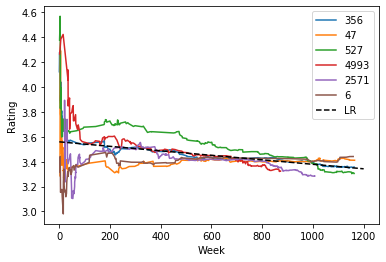

In [7]:
movie_list = [356, 47, 527, 4993, 2571, 6]
for movieId in movie_list:
    tdf = df[df.movieId == movieId].sort_values(by='timestamp')
    ratings_by_time = tdf.rating.groupby(tdf.timestamp).mean().reset_index(name='rating_mean_time')
    x = ratings_by_time.timestamp.to_list()
    y = []
    for i in range(len(ratings_by_time)):
        y.append(ratings_by_time.rating_mean_time.iloc[0:i].mean())
    plt.plot(x, y, label=movieId)
x = np.linspace(0,1200,5000)
y = k * x + b
plt.plot(x, y, 'k--', label='LR')
# x = np.linspace(0,1200,5000).reshape(-1, 1)
# y = clf.predict(x)
# plt.plot(x, y)
plt.legend()
plt.xlabel('Week')
plt.ylabel('Rating')

In [8]:
df['rating'] = df.apply(lambda x : x['rating'] - x['timestamp'] * k, axis=1)

In [9]:
timestamp_mean = df.timestamp.mean()
rating_mean_overall = df.rating.mean()
timestamp_mean, rating_mean_overall
tt = (df.timestamp - timestamp_mean).to_numpy()
rr = (df.rating - rating_mean_overall).to_numpy()
k = np.sum(tt * rr) / np.sum(tt * tt)
b = rating_mean_overall - k * timestamp_mean
k, b

(-4.5739824043798125e-20, 3.559645561645472)

Text(0, 0.5, 'Rating')

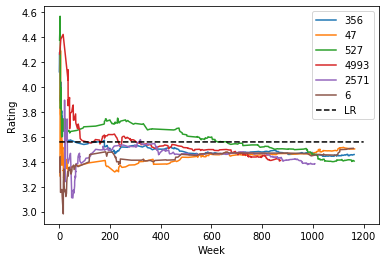

In [10]:
movie_list = [356, 47, 527, 4993, 2571, 6]
for movieId in movie_list:
    tdf = df[df.movieId == movieId].sort_values(by='timestamp')
    ratings_by_time = tdf.rating.groupby(tdf.timestamp).mean().reset_index(name='rating_mean_time')
    x = ratings_by_time.timestamp.to_list()
    y = []
    for i in range(len(ratings_by_time)):
        y.append(ratings_by_time.rating_mean_time.iloc[0:i].mean())
    plt.plot(x, y, label=movieId)
x = np.linspace(0,1200,5000)
y = k * x + b
plt.plot(x, y, 'k--', label='LR')
# x = np.linspace(0,1200,5000).reshape(-1, 1)
# y = clf.predict(x)
# plt.plot(x, y)
plt.legend()
plt.xlabel('Week')
plt.ylabel('Rating')

In [11]:
df.to_csv('ratings_dealt.csv', index=False)

# Splitting for 5-fold cross validation

In [12]:
set_user = set(df.userId.to_list())
set_movie = set(df.movieId.to_list())
len(set_user), len(set_movie)

(610, 9724)

In [13]:
random.seed(114514)
np.random.seed(114514)
df_musthave_user = df.groupby(df.userId, group_keys=False).apply(lambda x:x.sample(1))
df_musthave_movie = df.groupby(df.movieId, group_keys=False).apply(lambda x:x.sample(1))
df_musthave = pd.concat([df_musthave_user, df_musthave_movie]).drop_duplicates(subset=['userId', 'movieId'])
df_shuffled = df.sample(frac=1)
df_shuffled = pd.concat([df_musthave, df_shuffled]).drop_duplicates(keep=False) # Drop must have

In [14]:
folds = np.array_split(df_shuffled, 5)
for i in range(len(folds)):
    df_fold_train = pd.DataFrame()
    if i > 0: df_fold_train = pd.concat(folds[:i])
    if i + 1 < len(folds): df_fold_train = pd.concat([df_fold_train, pd.concat(folds[i+1:])])
    df_fold_train = pd.concat([df_fold_train, df_musthave])
    df_fold_test = folds[i]
    df_fold_train.to_csv('data/trainset_{}.csv'.format(i))
    df_fold_test.to_csv('data/testset_{}.csv'.format(i))
    print(df_fold_train.shape, df_fold_test.shape)

(82729, 4) (18107, 4)
(82729, 4) (18107, 4)
(82729, 4) (18107, 4)
(82730, 4) (18106, 4)
(82730, 4) (18106, 4)
